# Solucion tarea 5 - Aprendizaje Evolutivo (Algoritmo Genético para selección de características)

#### Estudiantes:
- Nicolás Prieto Escobar
- Pablo A. Saldarriaga Aristizabal

NOTA: Tener en cuenta que los tiempos de cómputo para varias de las celdas de este notebook son altos (varios minutos).

### Problema:

Contamos con información hora a hora para los barrios del poblado para los meses de junio a diciembre de 2017. Para cada hora tenemos la información de las condiciones climáticas del barrio, además de tener la etiqueta de si en esa hora ocurrió o no un accidente de tránsito. En base a la información disponible, se quiere predecir si un accidente ocurrirá a cierta hora de forma que agentes de movilidad, abogados de aseguradoras y demás entes puedan estar situados en lugares estratégicos para ir a atender el accidente.

El modelo que usaremos para predecir accidentes en un Random Forest. Lo que queremos hacer es este trabajo es seleccionar las mejores características para mejorar el rendimiento de este método. Para esta selección, usaremos un algoritmo genético, el cual funcionará como método de envoltura ya que para evaluar la función objetivo de cada solución usamos una métrica obtenida al usar Random Forest sobre el conjunto de validación.

Buscamos entonces hallar el mejor conjunto de características con ayuda de nuestro algoritmo genético.

In [15]:
%matplotlib notebook

### Importación de paquetes para correr este Notebook
(Varias de las funciones usadas internamente en el algoritmo genético estan en un archivo .py aparte).

In [41]:
### Basado en: https://towardsdatascience.com/feature-reduction-using-genetic-algorithm-with-python-403a5f4ef0c1
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import Archivos_auxiliares.GA as GA
import matplotlib.pyplot
import numpy as np
import random
import pandas as pd
import datetime as dt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score

### Lectura y preparación de los datos

En esta sección se hace toda la lectura y preparación de los datos para dejarlos en un dataframe que serán usados por el método. No se explica cada parte ya que esto ya se ha explicado en las demás tareas.

In [3]:

################### Leer datos
data = pd.read_csv('data/data_tarea5.csv', sep = ',')
data['TW'] = pd.to_datetime(data['TW'])

data['poblado'] = data['BARRIO']
data= pd.get_dummies(data, columns=['poblado'])

### Agregar otras features
data['hora'] = data['TW'].dt.hour
data['dia_sem'] = data['TW'].dt.dayofweek

data= pd.get_dummies(data, columns=['hora'])
data= pd.get_dummies(data, columns=['icon'])
data= pd.get_dummies(data, columns=['dia_sem'])

### Feature augmentation
freq = '5H'
variables = ['temperature','precipIntensity','apparentTemperature','dewPoint',
             'humidity','windSpeed','cloudCover','visibility']

data_aux = data.copy()
data_aux.index = data_aux.TW
data_aux = data_aux.sort_index()
data_aux = data_aux.drop(columns = 'TW')
resample_data = data_aux[variables].rolling(freq, closed = 'left').mean()

data_pivot = data_aux.pivot_table(values=variables, index='TW',columns='BARRIO', aggfunc=sum)
data_mean = data_pivot.rolling(freq, closed = 'left').mean().stack().reset_index(drop = False)

col_means = [*data_mean.columns[:2]]
for col in data_mean.columns[2:]:
    col_means.append(col + '_mean')
    
data_mean.columns = col_means

data = data.merge(data_mean, how = 'left', on = ['TW','BARRIO'])
data = data.dropna().reset_index(drop = True)


data_train = data[data['TW']<dt.datetime(2017,11,1)].reset_index(drop = True)
data_test = data[data['TW']>=dt.datetime(2017,11,1)].reset_index(drop = True)

X = data_train.drop("Accidente", 1).reset_index(drop=True)       # feature matrix 
y = data_train['Accidente'].reset_index(drop=True)               # target feature
X = X[X.columns[2:]]

X_test = data_test.drop("Accidente", 1).reset_index(drop=True)       # feature matrix 
y_test = data_test['Accidente'].reset_index(drop=True)               # target feature
X_test = X_test[X_test.columns[2:]]

X_train = X.copy()
y_train = y.copy()


### Train y validation split y undersampling
X['index'] = X.index
X_train1, X_val, y_train1, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

tra_0 = int(len(y_train1) - y_train1.sum())
tra_1 = int(y_train1.sum())

prop_deseada_under = 0.4
mul_updown = (tra_0 * prop_deseada_under - tra_1 * (1 - prop_deseada_under)) / (tra_0 * prop_deseada_under)   
fac_1 = int(tra_0 * (1 - mul_updown))

ratio_u = {0 : fac_1, 1 : tra_1}
rus = RandomUnderSampler(sampling_strategy = ratio_u, random_state=42)
X_train_under1, y_train_under1 = rus.fit_sample(X_train1, y_train1)

### Guardar y quitar los indices
train_indices = X_train_under1['index'].values
test_indices = X_val['index'].values
X = X.drop(['index'], axis=1)
X_train_under1 = X_train_under1.drop(['index'], axis=1)
X_val = X_val.drop(['index'], axis=1)





### Renombrar variables con los datos
data_inputs, data_outputs = X.values, y.values




## Samples
num_samples = data_inputs.shape[0]
num_feature_elements = data_inputs.shape[1]



print("Number of training samples: ", train_indices.shape[0])
print("Number of test samples: ", test_indices.shape[0])



Number of training samples:  3030
Number of test samples:  16153


### Selección de variables con método de envolutra (algoritmo genético)

En este trabajo, lo que usaremos entonces es un algoritmo genético para selección las variables más relevantes para nuestro problema.

Lo que usaremos es entonces un método de envoltura, ya que para medir la función objetivo de nuestras soluciones en el modelo lo que hacemos es ver el valor de la métrica de nuestro modelo en el conjunto de solución con las variables escogidas de cada solución del algoritmo. 

Nuestro algoritmo genético intenta hallar entonces la solución con mejor valor para nuestra métrica (en este caso, será balanced_accuracy) en el conjunto de validación (es monoobjetivo).

El modelo que usamos como base en la envoltura (en nuestro algoritmo genético) para evaluar la función objetivo (fitness) de cada solución es el modelo RandomForest, con unso hiperparámetros adecuados según el análisis que habíamos hecho en la tarea 3. 

En este caso, los dos hiperparámetros más importantes del Random Forest los cuales fijamos serán el número de árboles y la profundidad máxima de cada árbol. Usamos una profundidad máxima de 10 niveles tal como se había hallado en nuestra búsqueda de hiperparámetros. Además, usamos 100 árboles en el bosque, debido a que el análisis de sensbilidad nos había mostrado que usar más de 100 árboles traía mejoras muy leves, que costaban mucho tiempo de cómputo.

In [4]:
### Modelo base de la envoltura
classifier = RandomForestClassifier(max_depth = 10, random_state= 10, bootstrap = True, n_estimators = 100)

El siguiente método contiene la implementación del algoritmo genético. Usaremos este método para poder hacer varias distintas corridas del algoritmo genético más adelante cuando hagamos el análisis de sensbilidad. Esta función utiliza varias funciones auxiliares del archivo GA.py que se encuentra también en este github. 

El algoritmo genético tiene la misma estructura general que los de la literatura: crea una población inicial, luego sigue con las fases de selección, cruce y mutación, y repite estas 3 fases durante muchas generaciones de soluciones para encontrar la mejor solución de todas las evaluadas.

Un detalle importante que mencionamos es que creamos la población inicial de manera aleatoria, sin embargo, una de las soluciones iniciales la reemplazamos por las variables que habíamos seleccionado en la tarea 3, para poder contar con esta solución buena al inicio y darle una ayuda al modelo (en la primera generación, esta solución es la mejor de todas).

Los hiperparámetros de nuestro algoritmo genético son: el número de generaciones totales, el tamaño de la población, el porcentaje de mutación y por último el porcentaje de genes que son modificados cuando hay una mutación.

In [19]:

def genetic_algorithm(num_generations, sol_per_pop, porc_mutation, porc_genes):

    
    
    ### Fijar semillas
    SEED = 42
    random.seed(SEED)
    np.random.seed(SEED)
    
    # Defining the population shape.
    pop_shape = (sol_per_pop, num_feature_elements)

    # Crear poblacion inicial
    new_population = np.random.randint(low=0, high=2, size=pop_shape)
    #print(new_population.shape)

    num_parents_mating = int(sol_per_pop/2) # Cuantos padres se cruzaran 




    ### Le agrego las mejores variables que habiamos obtenido usando
    ### feature importances en la tarea 3, para que tenga una buena solucion
    ### al menos en el conjunto de las iniciales
    cols = ['apparentTemperature', 'temperature', 'humidity_mean',
           'temperature_mean', 'apparentTemperature_mean', 'humidity',
           'dewPoint_mean', 'dewPoint', 'windSpeed_mean', 'windSpeed',
           'cloudCover_mean', 'uvIndex', 'icon_partly-cloudy-night',
           'poblado_LaAguacatala', 'visibility_mean', 'cloudCover', 'dia_sem_6',
           'precipIntensity_mean', 'visibility', 'poblado_ElCastillo',
           'icon_partly-cloudy-day', 'poblado_VillaCarlota', 'poblado_Astorga',
           'precipIntensity', 'poblado_AltosdelPoblado', 'precipProbability',
           'hora_7', 'poblado_LosBalsosNo1', 'poblado_ElDiamanteNo2',
           'poblado_Manila', 'poblado_SantaMariadeLosÁngeles', 'poblado_Lalinde',
           'hora_3', 'hora_0', 'hora_1', 'dia_sem_4', 'dia_sem_5', 'hora_2',
           'poblado_ElPoblado', 'poblado_SanLucas', 'poblado_LasLomasNo2',
           'dia_sem_1', 'dia_sem_2', 'poblado_BarrioColombia',
           'poblado_LosBalsosNo2', 'hora_19', 'hora_4', 'dia_sem_3', 'dia_sem_0',
           'hora_17', 'hora_6', 'icon_cloudy']

    sol_original = []
    for i in X.columns:
        if i in cols:
            sol_original.append(1)
        else:
            sol_original.append(0)

    ### Reemplazo una solucion con esta
    new_population[0] = np.array(sol_original)





    ### Para ahorrar tiempos de computo, guardar las soluciones ya vistas
    ya_vistas = {}



    ####### Iterar por generaciones
    best_outputs = []
    for generation in range(num_generations):
        #print("Generation : ", generation)
        # Medir la funcion objetivo de la poblacion
        fitness, ya_vistas = GA.cal_pop_fitness(new_population, data_inputs, data_outputs, train_indices, test_indices, classifier, ya_vistas)
        best_outputs.append(np.max(fitness))


        ### Ver como va variando
        #print(np.sort(fitness)[::-1][:5])

        # Mejor resultado actualmente
        #print("Best result : ", best_outputs[-1])

        # Seleccion: simplemenete se eligen los mejores num_parents_mating para ser padres
        parents = GA.select_mating_pool(new_population, fitness, num_parents_mating)

        # Se hace el cruce: aqui se usa cruce por un punto
        # El hijo tendra un bloque de genes del padre 1, y otro bloque del padre 2
        offspring_crossover = GA.crossover(parents, offspring_size=(pop_shape[0]-parents.shape[0], num_feature_elements))

        # Se varian aleatoriamente algunos genes de algunos hijos
        offspring_mutation = GA.mutation(offspring_crossover, num_mutations=num_mutations, num_genes = num_genes)

        # Combino a los mejores padres y sus hijos, para tener la poblacion de la proxima generacion
        new_population[0:parents.shape[0], :] = parents
        new_population[parents.shape[0]:, :] = offspring_mutation



        
        
        
    #### Plotear los resultados obtenidos
    fitness, ya_vistas = GA.cal_pop_fitness(new_population, data_inputs, data_outputs, train_indices, test_indices, classifier, ya_vistas)
    best_match_idx = np.where(fitness == np.max(fitness))[0]
    best_match_idx = best_match_idx[0]

    best_solution = new_population[best_match_idx, :]
    best_solution_indices = np.where(best_solution == 1)[0]
    best_solution_num_elements = best_solution_indices.shape[0]
    best_solution_fitness = fitness[best_match_idx]

    print("Mejor solucion : ", best_solution)
    print("Indices seleccionados : ", best_solution_indices)
    print("Numero de variables seleccionadas : ", best_solution_num_elements)
    print("Balanced accuracy de la mejor solucion de todo el algoritmo : ", best_solution_fitness)

    matplotlib.pyplot.figure()
    matplotlib.pyplot.plot(best_outputs)
    matplotlib.pyplot.xlabel("Generacion")
    matplotlib.pyplot.ylabel("Mejor Balanced_Accuracy")
    matplotlib.pyplot.show()
    
    return best_solution, best_solution_indices, best_solution_num_elements, best_solution_fitness

### Ejecución del algoritmo genético con hiperparámetros adecuados y variables seleccionadas

Primero, mostremos el rendimiento del algoritmo genético con los hiperparámetros adecuados. Mostramos aquí estos resultados para poderlos comparar con los de la siguiente sección de análisis de sensibilidad. En dicha sección se encontrarán las justificaciones de por que se eligieron los hiperparámetros aquí presentados.

Mejor solucion :  [0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 1 0 1 0 0 1 0 1 1 0 1 1 1 0 1 1 1 0
 0 1 1 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0 0 0 1
 0 0 0 1]
Indices seleccionados :  [ 1  2  3  8  9 10 11 12 14 15 16 19 21 24 26 27 29 30 31 33 34 35 38 39
 41 42 46 48 51 52 53 55 59 60 61 62 66 67 68 69 73 77]
Numero de variables seleccionadas :  42
Balanced accuracy de la mejor solucion de todo el algoritmo :  0.7067664053471594


<IPython.core.display.Javascript object>


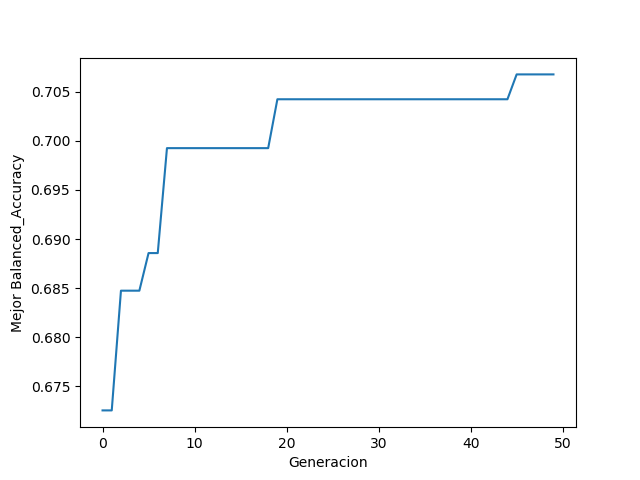

Tiempo corriendo: 365.1732680797577s


In [28]:
############ Hiperparametros
num_generations = 50   ### Numero de generaciones
sol_per_pop = 20 # Tamano de poblacion de cada generacion
num_parents_mating = int(sol_per_pop/2) # Cuantos padres se cruzaran 

porc_mutation = 0.2 # Proporcion de hijos a los que se le aplica el operador de mutacion.
num_mutations = int((sol_per_pop-num_parents_mating)*porc_mutation)

porc_genes = 0.05   ### Porcentaje de los genes que se varian al mutar
num_genes = int(num_feature_elements*porc_genes)


### Correr el algoritmo genético
time1 = time.time()
best_solution, best_solution_indices, best_solution_num_elements, best_solution_fitness = genetic_algorithm(num_generations, sol_per_pop, porc_mutation, porc_genes)
print('Tiempo corriendo: '+str(time.time() - time1)+'s')

Podemos ver que se obtienen resultados acorde a lo esperado en un algoritmo genético: vemos grandes y frecuentes mejoras en las primeras generaciones, pero después de un cierto tiempo, las mejoras se vuelven más espaciadas y menos considerables, por lo que probablemente no se obtengan ganancias muchas más grandes al permitir que itere por más generaciones (lo que aumentaría mucho el tiempo de cómputo). Se observa que logra mejorar mucho las soluciones iniciales (recordando que una de ellas era la usada en la tarea 3) y además obtiene un balanced accuracy de 0.7 en validation, lo cual se considera bueno. El tiempo de cómputo es de aproximadamente 6 minutos.

#### Rendimiento en test set de la solución obtenida y variables escogidas

Las variables elegidas por el algoritmo genético fueron las siguientes:

In [30]:
### Las variables obtenidas son
vars_obt = []
for i in range(len(best_solution)):
    if best_solution[i]==1:
        vars_obt.append(X.columns[i])
print(vars_obt)
print(len(vars_obt))

['precipProbability', 'temperature', 'apparentTemperature', 'uvIndex', 'visibility', 'poblado_Alejandria', 'poblado_AltosdelPoblado', 'poblado_Astorga', 'poblado_Castropol', 'poblado_ElCastillo', 'poblado_ElDiamanteNo2', 'poblado_LaAguacatala', 'poblado_Lalinde', 'poblado_LosBalsosNo1', 'poblado_LosNaranjos', 'poblado_Manila', 'poblado_SanLucas', 'poblado_SantaMariadeLosÁngeles', 'poblado_VillaCarlota', 'hora_1', 'hora_2', 'hora_3', 'hora_6', 'hora_7', 'hora_9', 'hora_10', 'hora_14', 'hora_16', 'hora_19', 'hora_20', 'hora_21', 'hora_23', 'icon_fog', 'icon_partly-cloudy-day', 'icon_partly-cloudy-night', 'icon_rain', 'dia_sem_3', 'dia_sem_4', 'dia_sem_5', 'dia_sem_6', 'humidity_mean', 'windSpeed_mean']
42


Podemos ver que son las variables obtenidas por el algoritmo genético son consistentes con las variables obtenidas en las tareas anteriores. Son de tres tipos principales: variables relacionadas con factores temporales (hora o día de la semana), relacionadas con el barrio o relacionadas con condiciones que indican tormenta (velocidad del viente, precipitación, nubes, etc). El sentido común nos indica que estas variables deben afectar la accidentalidad en la zona, por lo que consideramos como adecuadas las variables seleccionadas por el método.

El rendimiento de la solución en el conjunto de prueba con las mejores variables obtenidas por el algoritmo genético es el siguiente:





In [42]:
### Entrenar con variables elegidas
classifier.fit(X_train_under1[vars_obt],y_train_under1)

### evaluar en test, con variables elegidas
predicciones = classifier.predict(X_test[vars_obt])
probabilidades = classifier.predict_proba(X_test[vars_obt])[:,1]


fscore = f1_score(y_test, predicciones)
roc = roc_auc_score(y_test, probabilidades)
sensibilidad = recall_score(y_test, predicciones)
precision =precision_score(y_test, predicciones)
b_accuracy = balanced_accuracy_score(y_test, predicciones)

print(f'El roc es {roc}')
print(f'La sensibilidad es {sensibilidad}')
print(f'La precision es {precision}')
print(f'El fscore es {fscore}')
print(f'El balanced accuracy es {b_accuracy}')



El roc es 0.760439788942895
La sensibilidad es 0.5678119349005425
La precision es 0.048107859659874366
El fscore es 0.0887005649717514
El balanced accuracy es 0.6857698120245881


Vemos que de las medidas encontradas, tenemos buenos desempeños tal como ocurre con el ROC_AUC (obtiene un valor de 0.76 que se considera bastante bueno para un problema de alta complejidad como este). Igualmente vemos un valor alto en la sensibilidad (recall), para el f1_score y un valor bueno para el balanced accuracy. A pesar de que las métricas obtenidas en prueba son muy similares a las obtenidas con las variables escogidas en la tarea 3 (en la que se usó feature importance del random forest), vemos que aquí se usan 42 variables mientras que allá se usaban 52 variables, lo que supone una mejora considerable en tiempo de cómputo. Se puede concluir entonces que las variables escogidas por el método del algoritmo genético representan un buen conjunto de variables para resolver el problema y obtienen buenos resultados. Sin embargo, sería bueno como trabajo futuro ver si se puede mejorar su capacidad de generalizar (a pesar de que el algoritmo genético mejoró mucho la métrica en validación, al evaluar en el conjunto de prueba los resultados seguían siengo casi equivalentes a los de la tarea 3).


### Análisis de sensibilidad de sus hiperparámetros

Haremos un análisis de sensibilidad de los distintos hiperparámetros del algoritmo genético, para poder analizar los efectos de la escogencia de cada hiperparámetro y poder justificar la elección final de nuestros hiperparámetros.

##### Número de generaciones

El número de generaciones es el criterio de paradad utilizado en este método. Lo que vamos a analizar entonces es que ocurriría en los casos en que usaramos un número de generaciones muy bajo o muy alto, para poder mostrar la importancia de elegir un valor correcto para este hiperparámetro.


Primero, mostremos que ocurriría si se asigna un número de generaciones muy bajo, de solo 15 generaciones.

Mejor solucion :  [0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 0
 0 0 0 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1
 0 0 0 1]
Indices seleccionados :  [ 1  2  3  6  7  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25 27 29 30
 32 34 35 40 42 44 47 48 50 51 52 53 54 64 65 66 73 77]
Numero de variables seleccionadas :  42
Balanced accuracy de la mejor solucion de todo el algoritmo :  0.6992585189118281


<IPython.core.display.Javascript object>


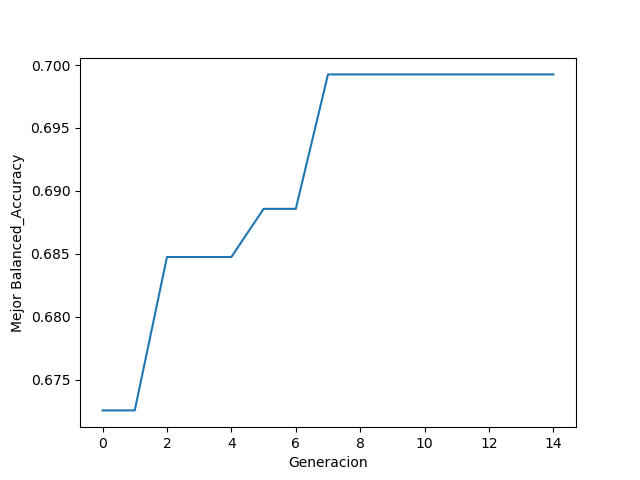

Tiempo corriendo: 121.18853092193604s


In [10]:
#### Resultados al usar un número muy bajo de generaciones
############ Hiperparametros
num_generations = 15   ### Numero de generaciones
sol_per_pop = 20 # Tamano de poblacion de cada generacion
num_parents_mating = int(sol_per_pop/2) # Cuantos padres se cruzaran 

porc_mutation = 0.2 # Proporcion de hijos a los que se le aplica el operador de mutacion.
num_mutations = int((sol_per_pop-num_parents_mating)*porc_mutation)

porc_genes = 0.05   ### Porcentaje de los genes que se varian al mutar
num_genes = int(num_feature_elements*porc_genes)


### Correr el algoritmo genético
time1 = time.time()
genetic_algorithm(num_generations, sol_per_pop, porc_mutation, porc_genes)
print('Tiempo corriendo: '+str(time.time() - time1)+'s')

Podemos ver que, tal como se esperaba, en las primeras generaciones ocurren muchas mejoras considerables y frecuentes en en el mejor valor de la función objetivo. 

Esto es un resultado adecuado para un algoritmo genético: al inicio, los cruces y mutaciones generarán mejoras muy significativas, las soluciones más débiles desaparecen en las primera generaciones mientras que las más fuertes se cruzan y se van creando rápidamente combinaciones de genes que mejoras mucho la solución.

Sin embargo, vemos que todo parcee indicar que hemos parado muy pronto el método: la gráfica estaba mostrando mejoras frecuentemente y de buena magnitud, y nos hemos detenido muy temprano (solo permitimos 15 generaciones). Se observa entonces que es correcto permitir un número de generaciones mayor en el método (el tiempo de cómputo aún es bajo, tardó 2 minutos).

Veamos ahora que ocurre si ponemos un valor muy grande en el número máximo de generaciones. Usaremos un máximo de 100 generaciones.

Mejor solucion :  [0 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1
 1 1 1 0 0 1 1 0 0 1 1 0 1 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 1 1 1 0 1
 0 0 1 0]
Indices seleccionados :  [ 2  3  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 25 28 30 31 32 33 35
 36 37 38 39 42 43 46 47 49 50 57 58 60 62 66 67 69 70 71 73 76]
Numero de variables seleccionadas :  45
Balanced accuracy de la mejor solucion de todo el algoritmo :  0.7102244640867872


<IPython.core.display.Javascript object>


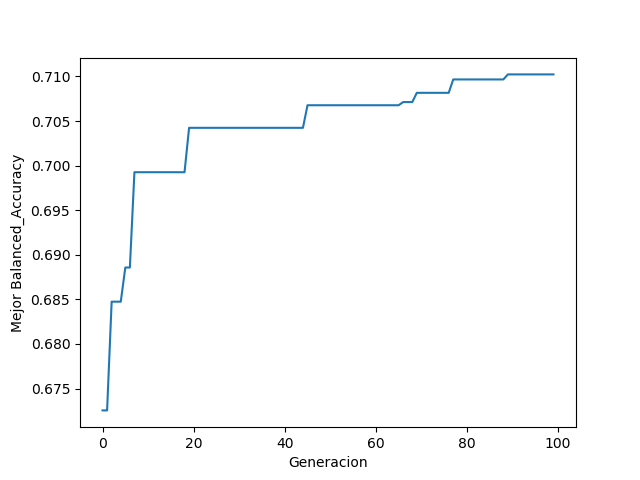

Tiempo corriendo: 687.2363078594208s


In [43]:
#### Resultados al usar un número muy alto de generaciones
############ Hiperparametros
num_generations = 100   ### Numero de generaciones
sol_per_pop = 20 # Tamano de poblacion de cada generacion
num_parents_mating = int(sol_per_pop/2) # Cuantos padres se cruzaran 

porc_mutation = 0.2 # Proporcion de hijos a los que se le aplica el operador de mutacion.
num_mutations = int((sol_per_pop-num_parents_mating)*porc_mutation)

porc_genes = 0.05   ### Porcentaje de los genes que se varian al mutar
num_genes = int(num_feature_elements*porc_genes)


### Correr el algoritmo genético
time1 = time.time()
genetic_algorithm(num_generations, sol_per_pop, porc_mutation, porc_genes)
print('Tiempo corriendo: '+str(time.time() - time1)+'s')

Podemos ver que, luego de la mejora rápida y significativa de las primeras generaciones, cada vez se van haciendo más espaciadas las generaciones en las que hay mejora, y cuando ocurren, las mejoras cada vez son menos significativas. Además, vemos que el tiempo total de cómputo fue de aproximadamente 12 minutos, lo cual es relativamente alto.

Este resultado es adecuado según lo que esperábamos: al inicio, hay muchas mejoras en un algoritmo genético. Sin embargo, a medida que van avanzando las generaciones, cada vez es más difícil encontrar individuos que superen a los mejores individuos que se han visto hasta ahora, y cuando esto ocurre, suelen ser mejoras muy leves y espaciadas. Este resultado es acorde con lo que la literatura indica de los algoritmos genéticos. Por esta razón, a pesar de que en generaciones muy avanzadas se siguen consiguiendo leves mejoras, podríamos considerar mejorar usar un número de generacioens mucho menor, de tal forma que logremos obtener soluciones casi igual de buenas pero sin requerir un tiempo de cómputo tan elevado como el de este caso.

Esto nos permitiría pensar entonces en que debemos usar un valor de número de generaciones equilibrado entre ambso extremos: suficiente para que alcance a explorar muchas soluciones, pero no puede ser demasiado alto hasta el punto que gaste un tiempo de cómputo muy elevado por ganancias poco significativas.

#### Porcentaje de mutación

Analicemos ahora que ocurre al variar el porcentaje de mutación.

En los algoritmos genéticos, al crear nuevas soluciones se decide que estas pueden ser creadas solo a partir de un cruce entre los genes de los padres o también pueden depender de una mutación. Aquí lo que buscamos es determinar el valor indicado de probabilidad a asignar para cruzar soluciones o para mutarlas.

En este algoritmo genético, lo que hacemos es que todas las soluciones primero son creadas a partir de un cruce, y luego un porcentaje de estas soluciones son mutadas (algunos de sus genes son modificados de forma aleatoria). El porcentaje de mutación hace referencia entonces al porcentaje de soluciones que son mutadas.

Evaluemos entonces que pasa al asignar porcentajes extremos de mutación.


Empecemos primero entonces evaluando que ocurre si no incluimos mutación en nuestro algoritmo genético. Para esto, vamos a usar un porcentaje de mutación de 0.

Mejor solucion :  [1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0
 1 0 1 1 0 1 0 1 1 0 0 1 0 0 1 1 0 1 0 1 0 0 1 1 1 0 1 1 0 1 0 1 1 1 0 0 1
 0 0 0 0]
Indices seleccionados :  [ 0  1  2  3  4  5  6  7  8  9 11 12 13 15 16 17 19 21 23 24 25 27 29 30
 31 32 33 34 35 37 39 40 42 44 45 48 51 52 54 56 59 60 61 63 64 66 68 69
 70 73]
Numero de variables seleccionadas :  50
Balanced accuracy de la mejor solucion de todo el algoritmo :  0.6914221611435591


<IPython.core.display.Javascript object>


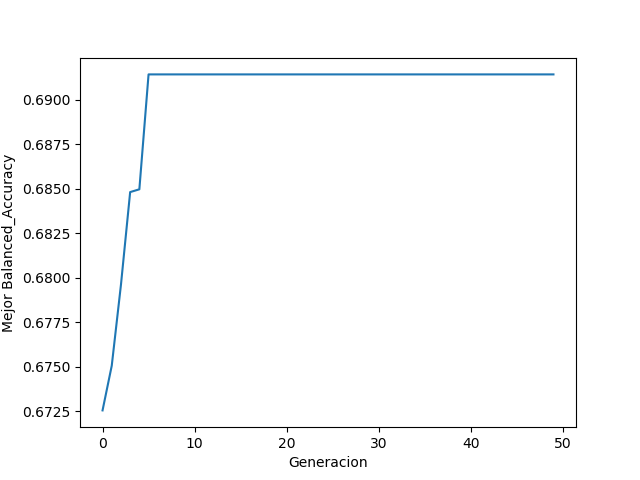

Tiempo corriendo: 98.44272923469543s


In [21]:
#### Resultados al no usar mutación
############ Hiperparametros
num_generations = 50   ### Numero de generaciones
sol_per_pop = 20 # Tamano de poblacion de cada generacion
num_parents_mating = int(sol_per_pop/2) # Cuantos padres se cruzaran 

porc_mutation = 0.0 # Proporcion de hijos a los que se le aplica el operador de mutacion.
num_mutations = int((sol_per_pop-num_parents_mating)*porc_mutation)

porc_genes = 0.05   ### Porcentaje de los genes que se varian al mutar
num_genes = int(num_feature_elements*porc_genes)


### Correr el algoritmo genético
time1 = time.time()
genetic_algorithm(num_generations, sol_per_pop, porc_mutation, porc_genes)

print('Tiempo corriendo: '+str(time.time() - time1)+'s')


Podemos ver que al inicio, hay mejoras muy rápidas y grandes de la función objetivo. Sin embargo, luego de pocas generaciones, se alcanza una solución objetivo máxima la cual no logra mejorarse más.

Estos resultados nos muestran muy claramente la importancia de la mutación en un algoritmo genético. Lo que aquí ha pasado es que al solo depender de los cruces entre los padres, el método ha podido encontrar grandes mejoras en las primeras generaciones (explotación). 

Sin embargo, luego de esto, el método llega a una etapa donde ya no logra mejorarse más: ya ha evaluado la mayoría de los posibles cruces entre padres, y además al analizar nosotros las soluciones hemos visto que empieza a generar los individuos duplicados. Al no haber mutación, todas las soluciones iban por el mismo camino y ahora todas son iguales o muy similares y se ha perdido la diversidad en la población, la cual es una propiedad fundamental para el algoritmo genético. Al no haber mutación, el algoritmo perdió la capacidad de buscar soluciones en espacios muy distintos a los de las soluciones actuales (explorar). Esto conlleva a que se estanque en un óptimo local, demostrando así la importancia del operador de mutación en el método.


Tengamos en cuenta que el bajo tiempo de cómputo (menos de 2 minutos) se puede explicar porque el algoritmo por dentro recuerda el valor objetivo de una cierta solución, y como lo que pasó en este caso fue que al no haber mutación toda la población terminó teniendo los mismo genes, casi nunca fue necesario evaluar la función objetivo desde cero ya que ésta ya se conocía.

Miremos ahora que ocurre cuando se usa un porcentaje de mutación muy alta (se mutan el 90% de las soluciones creadas):

Mejor solucion :  [0 0 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1
 1 1 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 1
 0 0 0 0]
Indices seleccionados :  [ 3  5  8  9 10 11 12 14 15 16 17 20 21 22 23 25 27 28 30 32 33 34 36 37
 38 39 41 46 48 51 52 55 57 59 62 64 67 69 73]
Numero de variables seleccionadas :  39
Balanced accuracy de la mejor solucion de todo el algoritmo :  0.6958733381224558


<IPython.core.display.Javascript object>


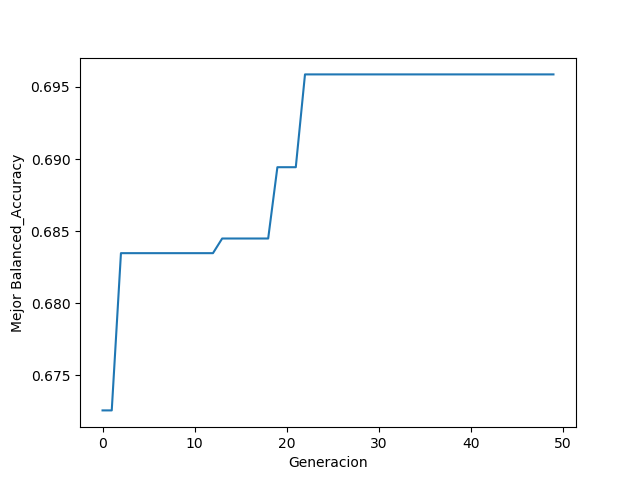

Tiempo corriendo: 378.71544551849365s


In [22]:
#### Resultados al usar un porcentaje de mutacion muy alto
############ Hiperparametros
num_generations = 50   ### Numero de generaciones
sol_per_pop = 20 # Tamano de poblacion de cada generacion
num_parents_mating = int(sol_per_pop/2) # Cuantos padres se cruzaran 

porc_mutation = 0.9 # Proporcion de hijos a los que se le aplica el operador de mutacion.
num_mutations = int((sol_per_pop-num_parents_mating)*porc_mutation)

porc_genes = 0.05   ### Porcentaje de los genes que se varian al mutar
num_genes = int(num_feature_elements*porc_genes)


### Correr el algoritmo genético
time1 = time.time()
genetic_algorithm(num_generations, sol_per_pop, porc_mutation, porc_genes)
print('Tiempo corriendo: '+str(time.time() - time1)+'s')

En los resultados anteriores, podemos ver que en las primeras generaciones se obtuvieron buenas mejoras. Sin embargo, vemos que luego de un número de generaciones (aproximadamente 20) no se encontraron más mejoras en la solución objetivo. Además, vemos que el mejor resultado hallado (0.695 balanced accuracy) es inferior al metodo final escogido que usaba un porcentaje de mutación más conservador de solo el 20%.

Estos resultados también soportan lo esperado: al usar un porcentaje de mutación tan alto, estamos restándole importancia al operador de cruce, el cual es el principal encargado de mejorar en un ámbito local las solucioknes al cruzar dos padres que deberían ser buenas soluciones. Le estamos dando mucha importancia a variar de formas aleatorias el espacio de solución (explorar), sin embargo, al usar tan pocos cruces, no estamos dándole suficiente importancia a tratar de mejorar mucho la solución en un ámbito local (explotar). Por esta razón, no se obtendrán resultados tan buenos si nos dedicamos a mutar casi todas las soluciones.

#### Tamaño de la población

Ahora, veamos que ocurre al variar el tamaño de la población. 

Primero, evaluemos que ocurre con un tamaño de la población más grande (32 soluciones por generación).

Mejor solucion :  [0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 1 1 1 0 1 0 1 1 1 0 0 1 0 1
 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 0 0 0 0 1 1 0 1 0 1
 0 0 1 0]
Indices seleccionados :  [ 2  6  7  8  9 11 12 13 15 16 18 19 23 24 25 27 29 30 31 34 36 41 42 46
 50 53 54 56 57 58 59 62 63 68 69 71 73 76]
Numero de variables seleccionadas :  38
Balanced accuracy de la mejor solucion de todo el algoritmo :  0.7088168785332791


<IPython.core.display.Javascript object>


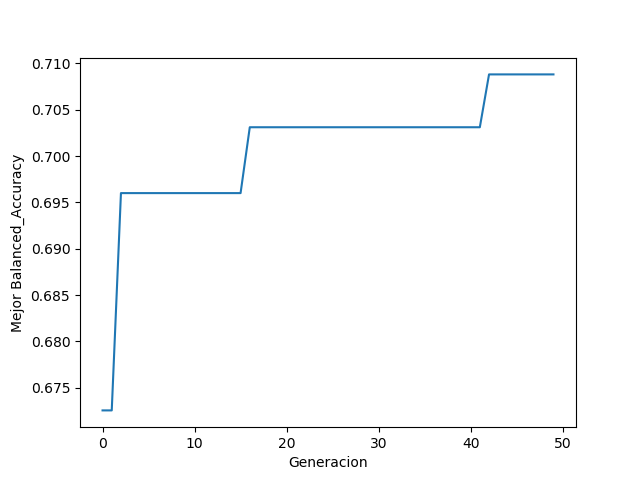

Tiempo corriendo: 565.0278441905975s


In [50]:
#### Resultados al usar una población más grande
############ Hiperparametros
num_generations = 50   ### Numero de generaciones
sol_per_pop = 32 # Tamano de poblacion de cada generacion
num_parents_mating = int(sol_per_pop/2) # Cuantos padres se cruzaran 

porc_mutation = 0.2 # Proporcion de hijos a los que se le aplica el operador de mutacion.
num_mutations = int((sol_per_pop-num_parents_mating)*porc_mutation)

porc_genes = 0.05   ### Porcentaje de los genes que se varian al mutar
num_genes = int(num_feature_elements*porc_genes)


### Correr el algoritmo genético
time1 = time.time()
genetic_algorithm(num_generations, sol_per_pop, porc_mutation, porc_genes)
print('Tiempo corriendo: '+str(time.time() - time1)+'s')

Podemos ver que los resultados son muy similares en calidad a los obtenidos al usar 20 soluciones, sin embargo, son levemente mejores. Esto probablemente se deba a que al usar 32 soluciones en vez de 20 en la población, se están evaluando muchas más posibles soluciones en la misma cantidad de generaciones, por lo que tiene sentido que al tener una población más alta se puedan encontrar mejores soluciones. Sin embargo, notar que el tiempo de cómputo pasó de 6 minutos a casi 10 minutos: al evaluar muchas más soluciones también aumentó bastante el tiempo de cómputo.

Ahora, veamos que ocurre al usar un tamaño de población pequeño (10 soluciones).

Mejor solucion :  [0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0
 0 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 0 1 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 1 1
 0 0 1 0]
Indices seleccionados :  [ 1  5 10 11 12 14 15 17 19 21 23 24 25 26 27 29 30 31 32 33 34 39 40 42
 43 44 47 48 49 50 53 55 59 61 62 64 66 67 69 72 73 76]
Numero de variables seleccionadas :  42
Balanced accuracy de la mejor solucion de todo el algoritmo :  0.7025751944279601


<IPython.core.display.Javascript object>


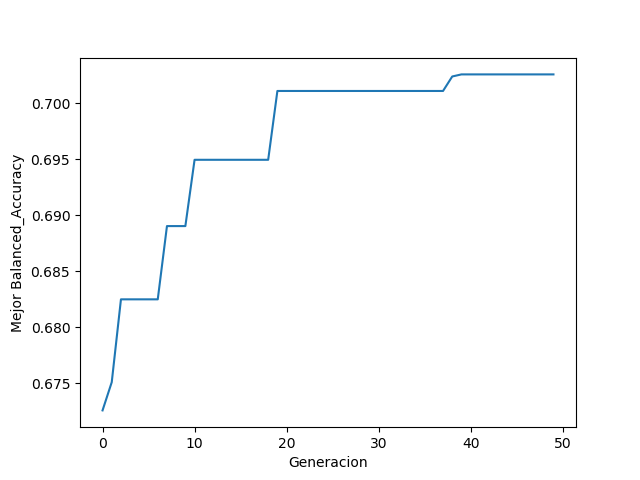

Tiempo corriendo: 177.33601593971252s


In [44]:
#### Resultados al usar una población más pequeña
############ Hiperparametros
num_generations = 50   ### Numero de generaciones
sol_per_pop = 10 # Tamano de poblacion de cada generacion
num_parents_mating = int(sol_per_pop/2) # Cuantos padres se cruzaran 

porc_mutation = 0.2 # Proporcion de hijos a los que se le aplica el operador de mutacion.
num_mutations = int((sol_per_pop-num_parents_mating)*porc_mutation)

porc_genes = 0.05   ### Porcentaje de los genes que se varian al mutar
num_genes = int(num_feature_elements*porc_genes)


### Correr el algoritmo genético
time1 = time.time()
genetic_algorithm(num_generations, sol_per_pop, porc_mutation, porc_genes)
print('Tiempo corriendo: '+str(time.time() - time1)+'s')

Como vemos en la gráfica, se logran obtener buenos resultados, y el comportamiento es similar a lo que esperamos en los genéticos (buenas y frecuentes mejoras al inicio, pero se van volviendo menos significativas y más espaciadas).

Comparando con el método final escogido, vemos que la solución, a pesar de ser buena, no es tan buena como la del método final. Esto se debe probablemente a que, al reducir la población a la mitad, solo permitimos evaluar la mitad de las soluciones evaludas por el método final. Al dejar de evaluar tantas soluciones, fue incapaz de lograr una solución tan buena. Sin embargo, notar que el tiempo de cómputo es de aproximadamente 3 minutos, prácticamente la mitad del tiempo usado por el método final (6 minutos), lo que tiene sentido ya que se redujo a la mitad el número de soluciones evaluadas. De esta forma, si se contara con muy poco tiempo, esta podría resultar una buena alternativa.

Al evaluar distintos tamaños de población, fue posible entonces ver que el trade-off entre tiempo de cómputo y calidad de la solución es evidente: al aumentar el tamaño de la población (y dejar las mismas generaciones), la calidad de la solución suele aumentar y también el tiempo de cómputo, y viceversa. Por ende, es necesario asignar un tamaño de la población adecuao para equilibrar ambos aspectos (calidad y tiempo de cómputo).

#### Porcentaje de genes mutados

En el último hiperpárametro a evaluar, veremos que ocurre cuando variamos el porcentaje de genes que se mutan.

Aquí solo consideramos el caso de variar un porcentaje muy alto de genes (80%). Tengamos en cuenta que variar un porcentaje de 0 sería equivalente a que no haya mutación, algo que ya analizamos antes.

Mejor solucion :  [1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1
 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1 1 1 1 1 0 0
 1 0 0 1]
Indices seleccionados :  [ 0  1  2  3  5  6  9 10 11 12 13 15 16 17 19 21 22 23 24 27 28 29 30 34
 35 36 38 41 42 43 48 56 58 61 65 67 68 69 70 71 74 77]
Numero de variables seleccionadas :  42
Balanced accuracy de la mejor solucion de todo el algoritmo :  0.6851151992170825


<IPython.core.display.Javascript object>


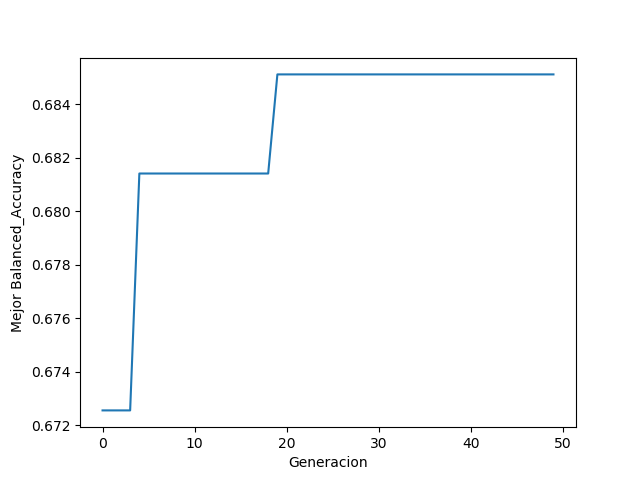

Tiempo corriendo: 430.357479095459s


In [26]:
#### Resultados al mutar muchos genes durante la mutación
############ Hiperparametros
num_generations = 50   ### Numero de generaciones
sol_per_pop = 20 # Tamano de poblacion de cada generacion
num_parents_mating = int(sol_per_pop/2) # Cuantos padres se cruzaran 

porc_mutation = 0.2 # Proporcion de hijos a los que se le aplica el operador de mutacion.
num_mutations = int((sol_per_pop-num_parents_mating)*porc_mutation)

porc_genes = 0.8   ### Porcentaje de los genes que se varian al mutar
num_genes = int(num_feature_elements*porc_genes)


### Correr el algoritmo genético
time1 = time.time()
genetic_algorithm(num_generations, sol_per_pop, porc_mutation, porc_genes)
print('Tiempo corriendo: '+str(time.time() - time1)+'s')

Podemos ver que, a pesar de obtener algunas mejoras buenas sobre todo en las generaciones iniciales, llegamos a un valor máximo de balanced_accuracy muy lejano al mejor obtenido por nuestro método final.

Esto tiene sentido con lo que esperábamos, debido a que al variar tantos genes durante la mutación, más que hacer una pequeña mutación para explorar otra posible zona buena estamos casi que cambiando por completo la solución. Esto conllevará entonces a que la solución mutada nos llevé a una zona muy diferente y que posiblemente no sea tan buena. Por esta razón, se debe considerar una mutación que permita que exploremos distintas zonas, pero no debería ser una mutación tan grande que prácticamente cambie por completo la solución, hasta el punto de llevarnos a algo completamente distinto (la solución mutada, al cambiar casi la totalidad de los genes, probablemente pierde también todos los bloques de genes que eran muy buenos que había logrado obtener con el pasar de las generaciones, dificultando así que tenga un buen rendimiento).

### Conclusión

Luego de analizados todos estos factores, podemos concluir que fue usando un algoritmo genético fue posible enecontrar las variables más relevantes para un modelo de Random Forest encargado predecir accidentes en la comuna del Poblado. Además, mostramos la importancia que tiene seleccionar bien los distintos hiperparámetros del algoritmo genético: el número de generaciones (suficientes para que se exploren varias soluciones, pero no exageradas), el porcentaje de mutación (de vital importancia para variar entre explorar y explotar y garantizar diversidad en la población), el tamaño de la población (relacionado directamente con el número de generaciones) y el porcentaje de genes que se mutan (no debe ser tan alto para procurar mantener algunos de los genes de las soluciones que se supone que son buenos).